In [2]:
# Simpel indlæsning af AIS Messages
import locale
import os
from timeit import default_timer as timer
import pandas as pd
import psutil
import cx_Oracle
locale.setlocale(locale.LC_ALL, 'Danish_Denmark.1252')
process = psutil.Process(os.getpid())
conn = cx_Oracle.connect('/@STATPROD')
tid = ["'2018-09-01 00:00:00'", "'2018-09-10 23:59:59'"]
t_fra, t_til = tid
print(t_fra, t_til)
sql = """
select a.*, 
       b.stype, 
       b.navn
from (
    select *
    from   (select p.tid,
                   round(p.tid,'MI') as tid_round,
                   p.aisnum,
                   p.repeat,
                   p.userid,
                   p.status,
                   p.rot,
                   p.sog,
                   p.posacc,
                   p.cog,
                   p.thead,
                   p.manind,
                   p.lon,
                   p.lat,
                   ROW_NUMBER()
                      OVER (PARTITION BY p.userid, round(p.tid,'MI')
                            ORDER BY p.tid) AS rownumber
            from u900001.aispos p
            where p.tid between timestamp {}
                            and timestamp {} and
                  p.lon between 7 and 16 and
                  p.lat between 54.5 and 58 and
                  p.sog = 0)
    where rownumber=1) a
join (
    select unique(a.userid) as userid,
           a.stype,
           a.navn
      from U900001.ais5 a
    where a.tid between timestamp {}
                     and timestamp {} and
          (a.stype between 40 and 49 or
          a.stype between 60 and 89)) b
on a.userid=b.userid

""".format(t_fra, t_til, t_fra, t_til)

start = timer()
df = pd.read_sql(sql, con=conn)
end = timer()
print(f"Rækker for dagen: {df.shape[0]:<n}")
print(f"Sekunder for indlæsning: {(end - start):<.1f}")
print(f"Memory forbrug: {round(process.memory_info().rss / 1024 / 1024):<n} Mbytes")
conn.close()



'2018-09-01 00:00:00' '2018-09-10 23:59:59'
Rækker for dagen: 2.196.599
Sekunder for indlæsning: 142.8
Memory forbrug: 1.383 Mbytes


In [2]:
%run -i HentHavne
havn = hent()
print(havn.head(2))


       FOT_ID  TIMEOF_CRE  TIMEOF_PUB TIMEOF_REV  TIMEOF_EXP  \
0  1000258581  2015-11-24  2015-11-24       None  2018-08-30   
1  1000258584  2015-11-24  2015-11-24       None  2018-08-30   

                                             omkreds  \
0  POLYGON ((11.92749754465786 55.93443663753771,...   
1  POLYGON ((11.90760580219009 55.93593141383621,...   

                                            geometry  
0  POLYGON ((11.92749754465786 55.93443663753771,...  
1  POLYGON ((11.90760580219009 55.93593141383621,...  


In [4]:
from math import radians, sin, cos, acos, atan2, sqrt

def calc_dist(koord, dkoord) :
    r = 6371.01  # jordens radius i km
    dlat, dlon = dkoord
    lat2, lon2 = koord
    lat1 = lat2 - dlat
    lon1 = lon2 - dlon
    rlat2 = radians(lat2)
    rlon2 = radians(lon2)
    rlat1 = radians(lat1)
    rlon1 = radians(lon1)

    drlon = rlon2 - rlon1
    drlat = rlat2 - rlat1
    
    a = sin(drlat / 2)**2 + cos(rlat2) * cos(rlat2) * sin(drlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    dist = 1000 * r * c
    return dist


# dkoord = (0.077791, 0.191818)
# koord = (57.399138, 11.318648)
# print("Distancen er {} meter".format(round(calc_dist(koord, dkoord),0)))

# geopy kan beregne det mere præcist, men det afhænger af qt, som giver installationsproblemer



In [5]:
# Vælg testskibe
import numpy as np
test = list(pd.Series(np.unique(df['USERID'])).sample(100))


In [13]:
print(test)


[265738540, 218179000, 212004000, 357672000, 275476000, 219003966, 304010688, 257226500, 265760070, 219014974, 219001284, 249412000, 219001771, 265547210, 205094000, 219000809, 211227270, 211881000, 211293940, 255805993, 220619000, 229774000, 376474000, 219000407, 311007200, 209445000, 219226000, 211314850, 219017917, 255805557, 265882000, 244855000, 235088102, 266225000, 304050000, 218858000, 219000899, 477170700, 219002418, 211190000, 219082000, 219016555, 356340000, 209392000, 219329000, 235066258, 265698740, 265463000, 266454000, 220474000, 244772000, 245176000, 266331000, 211189000, 257001890, 261517000, 266442000, 245573000, 245902000, 211230400, 219000605, 219024336, 265514120, 265527020, 209896000, 219001266, 235035113, 305575000, 305224000, 257340000, 255806082, 219416000, 256656000, 211379750, 269057081, 219805000, 219811000, 219000751, 265650950, 219000859, 258648000, 219000368, 305364000, 305983000, 219012639, 219010982, 538002828, 230666000, 354831000, 209183000, 319490000

In [6]:
testdata = df.loc[df['USERID'].isin(test)]
print(testdata.shape)
print(testdata.head())

(219639, 17)
                          TID           TID_ROUND  AISNUM  REPEAT     USERID  \
36633 2018-09-01 08:25:28.431 2018-09-01 08:25:00       3       0  244810418   
36634 2018-09-01 08:25:38.602 2018-09-01 08:26:00       3       0  244810418   
36635 2018-09-01 08:28:21.924 2018-09-01 08:28:00       3       0  244810418   
36636 2018-09-01 08:34:21.862 2018-09-01 08:34:00       3       0  244810418   
36637 2018-09-01 08:37:21.854 2018-09-01 08:37:00       3       0  244810418   

       STATUS  ROT  SOG  POSACC   COG  THEAD  MANIND        LON        LAT  \
36633       1    0    0       0  2212    288       0  10.631678  57.696845   
36634       1    0    0       0  2298    289       0  10.631675  57.696845   
36635       1    0    0       0  2449    301       0  10.631635  57.696847   
36636       1    0    0       0  2664    334       0  10.631315  57.696880   
36637       1    0    0       0  3027    351       0  10.631248  57.696887   

       ROWNUMBER  STYPE              

In [9]:
import numpy as np
import time

t0 = time.time()

# ALT DET HER KAN EVT PAKKES IND I df.pipe()

# Sorter efter skib og tid
testdata_s = testdata.sort_values(['USERID', 'TID'])
testdata_s.reset_index(drop=True, inplace=True)

# Beregn forskel ift forrige samt drop den første (som er missing)
# Omdøb tid og positioner
testdata2 = testdata_s[['TID', 'LON', 'LAT']].diff().dropna()
testdata2.columns = ['dTID', 'dLON', 'dLAT']
print(testdata2.head())

# Merge tilbage i data
testdata3 = pd.merge(testdata_s, testdata2, left_index=True, right_index=True)

# Beregn distance
def fetch_dist(row) :
    return calc_dist((row['LAT'], row['LON']), (row['dLAT'], row['dLON']))
    
testdata3['DISTANCE'] = testdata3.apply(fetch_dist, axis=1)
# Beregn hastighed
def hast(row) :
    if row['dTID'].total_seconds()==0 :
        return np.nan
    else :
        return row['DISTANCE'] / row['dTID'].total_seconds() * 60**2 / 1852
    
testdata3['KNOB'] = testdata3.apply(hast, axis=1)
print(testdata3.head())

t1 = time.time()
dt = t1 - t0
print("Procestiden har været {} minutter og {} sekunder.".format(int(dt / 60), round(dt%60, 2)))

                   TID           LON           LAT
1      00:00:19.702000  1.600000e-05  1.000000e-06
2      00:02:09.340000  9.000000e-05  5.900000e-05
3      00:00:49.530000  0.000000e+00 -4.000000e-06
4      00:01:00.045000 -1.000000e-06  4.000000e-06
5      00:01:00.014000  1.000000e-06  0.000000e+00
6      00:00:59.998000 -1.000000e-06  0.000000e+00
7      00:01:00.092000  1.000000e-06  1.000000e-06
8      00:00:59.873000 -1.000000e-06 -1.000000e-06
9      00:02:38.683000  0.000000e+00  0.000000e+00
10     00:02:59.979000  0.000000e+00  0.000000e+00
11     00:02:59.636000 -2.000000e-06  0.000000e+00
12     00:03:00.447000  0.000000e+00  0.000000e+00
13     00:02:59.808000  2.000000e-06  0.000000e+00
14     00:03:00.525000  1.000000e-06  0.000000e+00
15     00:02:59.854000 -1.000000e-05 -5.000000e-06
16     00:02:59.870000  0.000000e+00  0.000000e+00
17     00:02:59.979000 -1.000000e-06 -2.000000e-06
18     00:03:00.511000  0.000000e+00  0.000000e+00
19     00:03:00.244000  0.00000

## Procedure til at reducere datamængden
### Behold records, hvor skibet starter med at ligge stille og slutter med at ligge stille
### Skibe, der bevæger sig, frasorteres

In [128]:
t0 = timer()
ind = len(testdata)

dict_container = {}

def behandling(row) :
    if row['USERID'] in list(dict_container.keys()) :
        tid0, lon0, lat0, move0 = dict_container[row['USERID']]
        dlat = row['LAT'] - lat0
        dlon = row['LON'] - lon0
        distance = calc_dist((row['LAT'], row['LON']), (dlat, dlon))
#         0 --> 1 : ny rec i dict
#         1 --> 0 : do.
#         0 --> 0 : ikke ny
#         1 --> 1 : ny rec
        if distance > 2 :
            move = 1
        else :
            move = 0
        if move0 + move != 0 :
            dict_container[row['USERID']] = [row['TID'], row['LON'], row['LAT'], move]
        if move == move0 :
            return False
        else :
            return True
    else :
        dict_container[row['USERID']] = [row['TID'], row['LON'], row['LAT'], 0]
#         print(len(dict_container))
        return True
        

test_df = testdata[testdata.apply(behandling, axis=1)]

ud = len(test_df)

t1 = timer()
print("Procestiden har været {} minutter og {} sekunder.".format(int((t1-t0) / 60), round((t1-t0)%60, 2)))
print("Input var {} records og output er {} records.".format(ind, ud))
print("Procestid per million records er {} sekunder".format(round(1000000 * (t1 - t0) / (ind)), 2))

Procestiden har været 0 minutter og 48.57 sekunder.
Input var 409439 records og output er 44624 records.
Procestid per million records er 119 sekunder


In [131]:
print(dict_container)
print(len(test_df))
print(test_df.sort_values(['USERID', 'TID']).head())


In [129]:
# Omdan df til geopandas df
import geopandas
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(test_df.LON, test_df.LAT)]
# df = df.drop(['Lon', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = geopandas.GeoDataFrame(test_df, crs=crs, geometry=geometry)

In [7]:
# testdata3.groupby(by='USERID').max()

# PLOT af bevægelser

In [10]:
# Omdan df til geopandas df
import geopandas
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df.LON, df.LAT)]
# df = df.drop(['Lon', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)

In [11]:
from matplotlib import pyplot as plt
t0 = time.time()

url = 'geodata/NUTS_RG_01M_2016_4326_LEVL_3.geojson'
nuts3 = geopandas.read_file(url)
nuts3_dk = nuts3[nuts3['CNTR_CODE'].isin(['DK'])]
nuts3_dk2 = nuts3_dk.to_crs({'init': 'epsg:4326'})

fig, ax = plt.subplots(figsize=(20,15))
nuts3_dk2.plot(ax=ax, color='Lightgreen')
gdf.plot(ax=ax, column='USERID', markersize=2, marker='*')

ax.set_axis_off()

ax.set_title('Skibe med hastighed 0 knob. Sample=100', loc='center',
             fontdict={'family': 'Times New Roman', 'fontsize': '20', 'fontweight': 3})


t1 = time.time()
dt = t1 - t0
print("Procestiden har været {} minutter og {} sekunder.".format(int(dt / 60), round(dt%60, 2)))

fig.savefig('figurer/AIS 0 knob.png')

Procestiden har været 1 minutter og 50.84 sekunder.


      id CNTR_CODE                            NUTS_NAME  LEVL_CODE    FID  \
3  DE600        DE                              Hamburg          3  DE600   
4  DE711        DE          Darmstadt, Kreisfreie Stadt          3  DE711   
5  DE712        DE  Frankfurt am Main, Kreisfreie Stadt          3  DE712   
6  DE713        DE  Offenbach am Main, Kreisfreie Stadt          3  DE713   
7  DE714        DE          Wiesbaden, Kreisfreie Stadt          3  DE714   

  NUTS_ID                                           geometry NUTS1  
3   DE600  (POLYGON ((9.94538 53.65293, 9.95059 53.65084,...   DE6  
4   DE711  POLYGON ((8.725709999999999 49.95421, 8.734529...   DE7  
5   DE712  POLYGON ((8.59024 50.15954, 8.58867 50.16843, ...   DE7  
6   DE713  POLYGON ((8.717829999999999 50.06241, 8.734069...   DE7  
7   DE714  POLYGON ((8.32765 50.14589, 8.32239 50.14425, ...   DE7  


C:\Users\pot\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


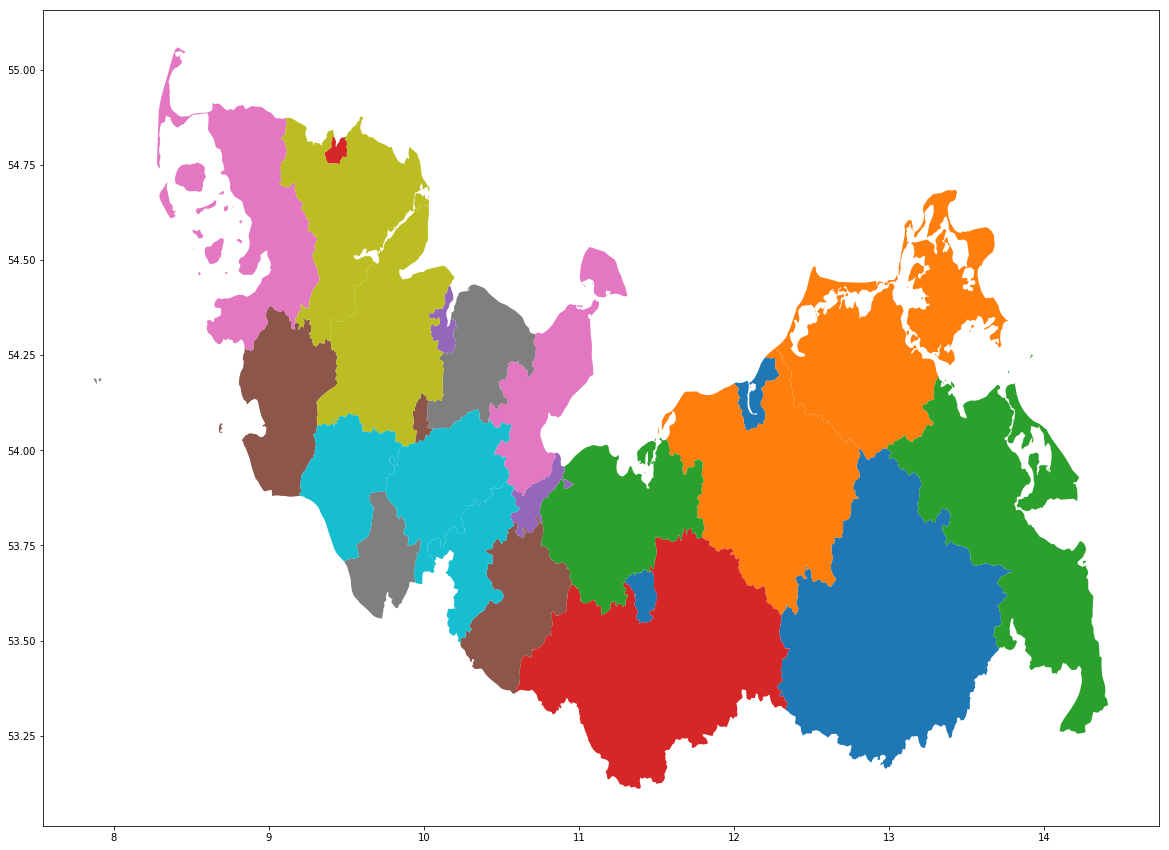

In [83]:
nuts3_de['NUTS1'] = nuts3['NUTS_ID'].str[:3]
# print(nuts3_de.head())
nuts3_de2 = nuts3_de[nuts3_de['NUTS1'].isin(['DEF', 'DE8'])]
fig, ax = plt.subplots(figsize=(20,15))
nuts3_de2.plot(ax=ax, column='NUTS_ID')

# print(nuts3_de2)

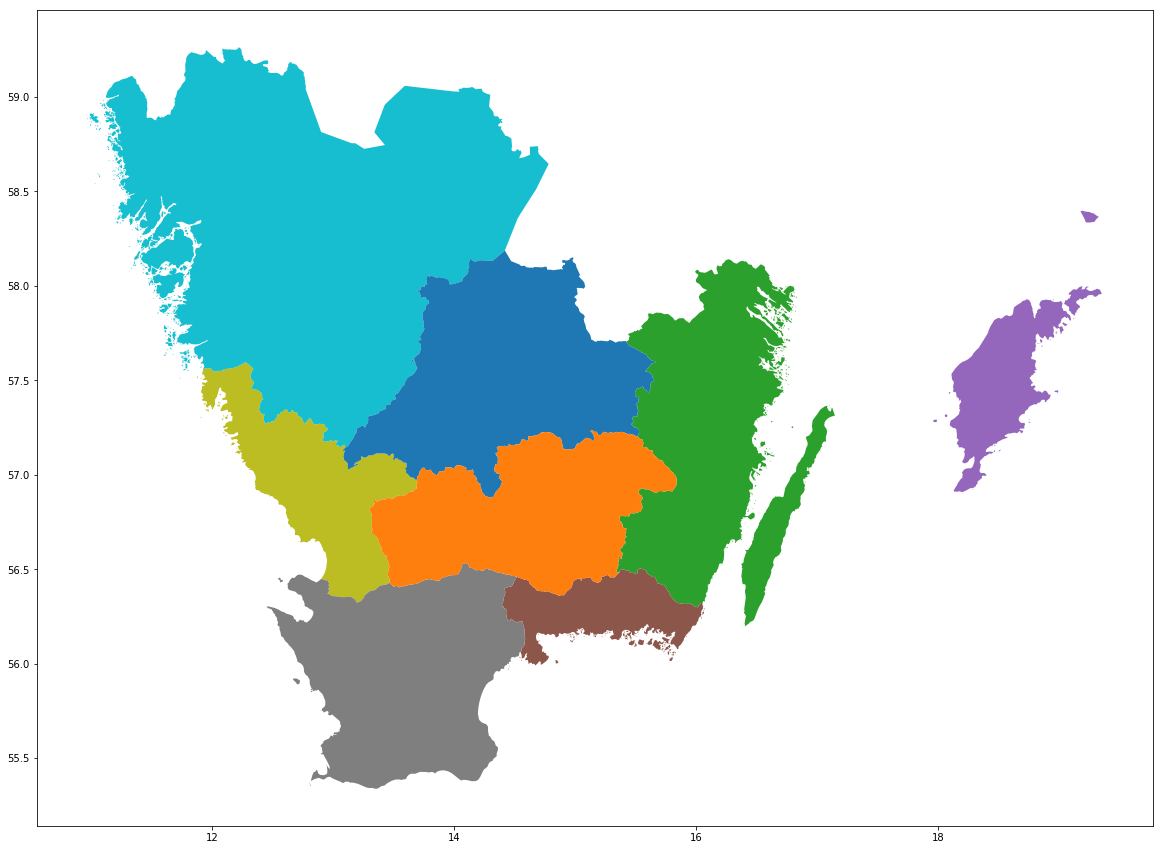

In [87]:
nuts3['NUTS1'] = nuts3['NUTS_ID'].str[:3]
nuts3_se = nuts3[nuts3['NUTS1'].isin(['SE2'])]
fig, ax = plt.subplots(figsize=(20,15))
nuts3_se.plot(ax=ax, column='NUTS_ID')
